<a href="https://colab.research.google.com/github/REELICIT/reqbrain_rep_package/blob/f843d8ea981c18cb7ed68b424bb78fec8fd44cd8/evaluation_scripts/paper_visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Common imports

- below cells are resulting in two figures that are used as part of the paper.

In [1]:
import datasets

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

# Instruct Dataset Training and Validation Sets Distribution (Fig. 2 on the paper)

In [2]:
tt_dataset = datasets.load_from_disk('../instruct_datasets/falcon_requirement_generation_dataset/')

In [3]:
tt_dataset

DatasetDict({
    train: Dataset({
        features: ['REQID_ex', 'completion', 'query', 'class', 'task', 'text', 'label'],
        num_rows: 132
    })
    test: Dataset({
        features: ['REQID_ex', 'completion', 'query', 'class', 'task', 'text', 'label'],
        num_rows: 34
    })
})

In [7]:
# Renaming some columns

def rename_tasks(column):
    task_mapping = {'NF-TYPES-TASK-PROMISE': 'RE-types INST',
                    'NF-TYPES-TASK-PO': 'RE-types INST',
                    'MISSING-TASK-5-SHORTENED': 'Missing INST',
                    'HOW-TO-WRITE-REQUIRMENT-TASK-SWARD-BASED': 'How-to? INST'}
    tasks = column['task']
    if isinstance(tasks, str):
        tasks = task_mapping[tasks]
    
    if isinstance(tasks, list):
        renamed_list = []
        for task in tasks:
            renamed_list.append(task_mapping[task])
        tasks = renamed_list

    return {'renamed_tasks': tasks}

In [8]:
tt_dataset = tt_dataset.map(rename_tasks, batched = True)

In [9]:
train_distro = np.unique(tt_dataset['train']['renamed_tasks'], return_counts = True)
test_distro = np.unique(tt_dataset['test']['renamed_tasks'], return_counts = True)

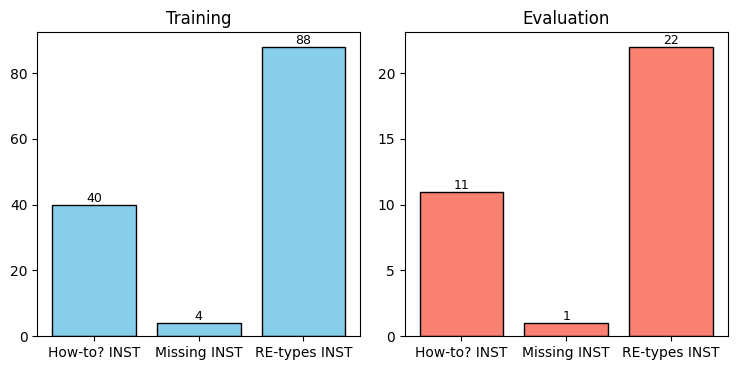

In [10]:
plt.figure(figsize=(7.5, 3.8))

# ploting the training set
plt.subplot(121)
bars_train = plt.bar(train_distro[0], train_distro[1], color='skyblue', edgecolor='black')
plt.xticks(rotation=0)
plt.title('Training')

for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', color='black', fontsize=9)

# ploting evaluation set
plt.subplot(122)
bars_test = plt.bar(test_distro[0], test_distro[1], color = 'salmon', edgecolor='black')
plt.title('Evaluation')
plt.xticks(rotation=0)

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', color='black', fontsize=9)

plt.tight_layout()
plt.savefig('./train_eval_set.pdf', bbox_inches = 'tight')
plt.show()

# Spider Chart: Evaluating Models per Task (BERT and FRUGAL scores) (extra: not presented on the paper)

In [12]:
# Loading the dataset
# dataset_for_spider_chart dataset is equalent to previously loaded dataset, it contains some
# columns differently formated such that could be ploted as spider (radar) chart

spider_chart_dataset = datasets.load_from_disk('./dataset_for_spider_chart/')
spider_chart_dataset = spider_chart_dataset.map(rename_tasks, batched = True)
spider_chart_dataset.set_format(type = 'pandas')
spider_chart_df = spider_chart_dataset[:]
spider_chart_dataset.reset_format()

In [14]:
# isolating columns that contain scores with respect to each score

frugal_labels = spider_chart_df.columns[-11:-1].to_numpy()[0::2]
bert_labels = spider_chart_df.columns[-10:].to_numpy()[0::2]

In [15]:
# rconverting the scores from 0 - 1 to 0 - 100 and rounding them up

frugal_stats = spider_chart_df.groupby(by = 'renamed_tasks')[frugal_labels].mean() * 100
frugal_stats = frugal_stats.applymap(lambda x: np.ceil(x)).astype(int)

bert_stats = spider_chart_df.groupby(by = 'renamed_tasks')[bert_labels].mean() * 100
bert_stats = bert_stats.applymap(lambda x: np.ceil(x)).astype(int)

frugal_stats = frugal_stats.T
bert_stats = bert_stats.T

/scratch/slurm_tmpdir/job_23071420/ipykernel_113619/3950167358.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  frugal_stats = frugal_stats.applymap(lambda x: np.ceil(x)).astype(int)
/scratch/slurm_tmpdir/job_23071420/ipykernel_113619/3950167358.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  bert_stats = bert_stats.applymap(lambda x: np.ceil(x)).astype(int)


In [13]:
frugal_stats

renamed_tasks,How-to? INST,Missing INST,RE-types INST
zephyr_frugal_score,90,87,93
mistralai_frugal_score,88,88,90
falcon_base_frugal_score,88,86,90
falcon_frugal_score,87,86,90
llama_frugal_score,87,87,90


In [14]:
bert_stats

renamed_tasks,How-to? INST,Missing INST,RE-types INST
zephyr_bert_score,89,87,91
mistralai_bert_score,88,90,90
falcon_base_bert_score,79,79,85
falcon_bert_score,87,82,90
llama_bert_score,80,88,89


In [15]:
label_mapper = {
    'zephyr_bert_score': 'Zephyr-7b-beta',
    'mistralai_bert_score': 'Mistral-7B-Instruct-v0.2',
    'falcon_base_bert_score': 'Falcon-7b',
    'falcon_bert_score': 'Falcon-7b-instruct',
    'llama_bert_score': 'Llama-2-7b-chat-hf',
    'zephyr_frugal_score': 'Zephyr-7b-beta',
    'mistralai_frugal_score': 'Mistral-7B-Instruct-v0.2',
    'falcon_base_frugal_score': 'Falcon-7b',
    'falcon_frugal_score': 'Falcon-7b-instruct',
    'llama_frugal_score':  'Llama-2-7b-chat-hf'
}

In [16]:
frugal_labels = frugal_stats.columns.to_numpy()
frugal_values = frugal_stats.values
frugal_line_names = frugal_stats.index.to_numpy()

In [17]:
bert_labels = bert_stats.columns.to_numpy()
bert_values = bert_stats.values
bert_line_names = bert_stats.index.to_numpy()

In [18]:
bert_line_names

array(['zephyr_bert_score', 'mistralai_bert_score',
       'falcon_base_bert_score', 'falcon_bert_score', 'llama_bert_score'],
      dtype=object)

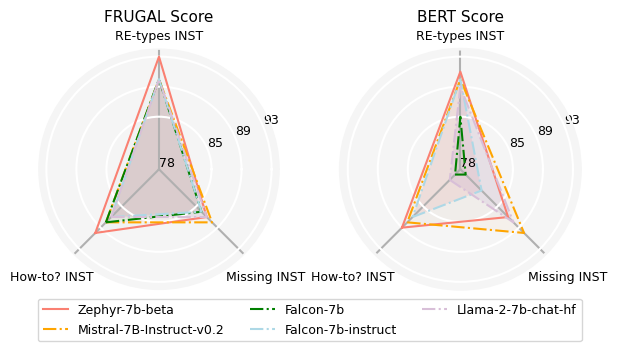

In [19]:
import matplotlib.colors as mcolors


custom_colors = ['#FA8072', '#FFA500', '#008000', '#ADD8E6',  '#D8BFD8']

custom_cmap = mcolors.ListedColormap(custom_colors)
line_colors = custom_colors

title_plot_1 = 'FRUGAL Score'
labels_plot_1 = frugal_labels
values_plot_1 = frugal_values
line_names_plot_1 = [label_mapper[model_name] for model_name in frugal_line_names]

title_plot_2 = 'BERT Score'
labels_plot_2 = bert_labels
values_plot_2 = bert_values
line_names_plot_2 = [label_mapper[model_name] for model_name in bert_line_names]

num_vars = len(labels_plot_1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.1), subplot_kw=dict(polar=True))

# angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles_degrees = [225, 315, 90]
angles = np.deg2rad(angles_degrees).tolist()

angles += angles[:1]

# Plot for the first subplot
ax1.set_title(title_plot_1, pad = 20, fontsize = 11)
ax1.set_facecolor('whitesmoke') 
ax1.set_ylim(78, 94)  
ax1.set_yticks([78, 85, 89, 93]) 

line_styles = ['-', '-.', '-.', '-.', '-.']  
for i, val in enumerate(values_plot_1):
    val_closed = np.append(val, val[0])
    ax1.plot(angles, val_closed, linewidth = 1.5, linestyle=line_styles[i % len(line_styles)], label=line_names_plot_1[i], color=line_colors[i])
    ax1.fill(angles, val_closed, alpha=0.02 * (i+1))


label_angles_1 = np.linspace(0, 2 * np.pi, len(labels_plot_1), endpoint=False).tolist()
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(labels_plot_1, rotation=0, ha='center') 


ax1.spines['polar'].set_color('whitesmoke')
ax1.spines['polar'].set_linewidth(1)
ax1.yaxis.grid(True, color='white')

ax1.tick_params(colors= 'black', width = 50, labelsize = 9, grid_linewidth = 1.5, grid_linestyle = '-') 

ticks = ax1.get_xticklabels()
paddings = [-0.1, -0.1, 0.05] 
for tick, pad in zip(ticks, paddings):
    tick.set_position((tick.get_position()[0], pad))
    
# Plot for the second subplot
ax2.set_title(title_plot_2, pad = 20, fontsize= 11)
ax2.set_facecolor('whitesmoke')  
ax2.set_ylim(78, 94)  
ax2.set_yticks([78, 85, 89, 93])  

for i, val in enumerate(values_plot_2):
    val_closed = np.append(val, val[0])
    ax2.plot(angles, val_closed, linewidth = 1.5, linestyle = line_styles[i % len(line_styles)], label=line_names_plot_2[i], color=line_colors[i])
    ax2.fill(angles, val_closed, alpha=0.02 * (i+1))


label_angles_2 = np.linspace(0, 2 * np.pi, len(labels_plot_2), endpoint=False).tolist()
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(labels_plot_2, rotation = 0, ha = 'center')  

    
ax2.spines['polar'].set_color('whitesmoke')
ax2.spines['polar'].set_linewidth(2)
ax2.yaxis.grid(True, color = 'white')

ax2.tick_params(colors= 'black', width = 50, labelsize = 9, grid_linewidth = 1.5, grid_linestyle = '-')


ticks = ax2.get_xticklabels()
paddings = [-0.1, -0.1, 0.05] 
for tick, pad, rot in zip(ticks, paddings, angles):
    tick.set_position((tick.get_position()[0], pad))

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol = 3, fontsize = 9, )


plt.subplots_adjust(wspace = -0.7) 
plt.tight_layout()
plt.savefig('./spider_chart.pdf', bbox_inches = 'tight')

plt.show()